***Business Problem***

The e-commerce company is experiencing fluctuating revenue growth and wants to understand customer purchasing behavior, category performance, and the effectiveness of marketing spend and discount strategies in order to improve profitability and long-term customer value.

**Project Objectives**

Analyze overall revenue trends and category-wise performance.

Understand customer purchasing patterns and identify high-value customers.

Evaluate the impact of discounts and marketing spend on revenue.

Perform cohort-based analysis to study repeat purchasing behavior.

Provide data-driven business recommendations to improve revenue and profitability

**Key Metrics (KPIs)**

Gross Revenue

Net Revenue (after tax & discounts)

Average Order Value (AOV)

Customer Lifetime Value (proxy)

Repeat Purchase Rate

Revenue per Customer

Marketing ROI

In [8]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)


In [10]:
import os
os.listdir("/kaggle/input")


['marketing-insights-for-e-commerce-company']

In [11]:
os.listdir("/kaggle/input/marketing-insights-for-e-commerce-company")


['Online_Sales.csv',
 'CustomersData.xlsx',
 'Marketing_Spend.csv',
 'Discount_Coupon.csv',
 'Tax_amount.xlsx']

In [12]:
base_path = "/kaggle/input/marketing-insights-for-e-commerce-company"

customers = pd.read_excel(f"{base_path}/CustomersData.xlsx")
sales = pd.read_csv(f"{base_path}/Online_Sales.csv")
marketing = pd.read_csv(f"{base_path}/Marketing_Spend.csv")
discount = pd.read_csv(f"{base_path}/Discount_Coupon.csv")
tax = pd.read_excel(f"{base_path}/Tax_amount.xlsx")


In [13]:
print(customers.shape)
print(sales.shape)
print(marketing.shape)
print(discount.shape)
print(tax.shape)

(1468, 4)
(52924, 10)
(365, 3)
(204, 4)
(20, 2)


In [14]:
customers.head()


,CustomerID,Gender,Location,Tenure_Months
0,17850,M,Chicago,12
1,13047,M,California,43
2,12583,M,Chicago,33
3,13748,F,California,30
4,15100,M,California,49


DATA LOADING END AND CLEANING INITIATED

In [16]:
customers.head(),sales.head(),marketing.head(),discount.head(),sales.head()

(   CustomerID Gender    Location  Tenure_Months
 0       17850      M     Chicago             12
 1       13047      M  California             43
 2       12583      M     Chicago             33
 3       13748      F  California             30
 4       15100      M  California             49,
    CustomerID  Transaction_ID Transaction_Date     Product_SKU  \
 0       17850           16679         1/1/2019  GGOENEBJ079499   
 1       17850           16680         1/1/2019  GGOENEBJ079499   
 2       17850           16681         1/1/2019  GGOEGFKQ020399   
 3       17850           16682         1/1/2019  GGOEGAAB010516   
 4       17850           16682         1/1/2019  GGOEGBJL013999   
 
                                  Product_Description Product_Category  \
 0  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
 1  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
 2              Google Laptop and Cell Phone Stickers           Office   
 3  G

In [21]:
# Remove duplicates
customers = customers.drop_duplicates()
sales = sales.drop_duplicates()
marketing = marketing.drop_duplicates()
discount = discount.drop_duplicates()
tax = tax.drop_duplicates()

# Handle missing values safely
if 'marketing_spend' in marketing.columns:
    marketing['marketing_spend'] = marketing['marketing_spend'].fillna(0)

if 'discount_pct' in discount.columns:
    discount['discount_pct'] = discount['discount_pct'].fillna(0)


In [22]:
marketing.isna().sum(), discount.isna().sum()


(Date             0
 Offline_Spend    0
 Online_Spend     0
 dtype: int64,
 Month               0
 Product_Category    0
 Coupon_Code         0
 Discount_pct        0
 dtype: int64)

In [25]:
print(sales.columns)

Index(['CustomerID', 'Transaction_ID', 'Transaction_Date', 'Product_SKU',
       'Product_Description', 'Product_Category', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Coupon_Status'],
      dtype='object')


In [26]:
sales.columns = (
    sales.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)


In [28]:
sales.rename(columns={
    'customerid': 'customer_id',
    'transaction_date': 'order_date',
    'product_category': 'category'
}, inplace=True)


In [29]:
sales['order_date'] = pd.to_datetime(sales['order_date'])

sales['order_month'] = sales['order_date'].dt.to_period('M').astype(str)


In [30]:
sales[['customer_id', 'order_date', 'order_month', 'category']].head()


,customer_id,order_date,order_month,category
0,17850,2019-01-01,2019-01,Nest-USA
1,17850,2019-01-01,2019-01,Nest-USA
2,17850,2019-01-01,2019-01,Office
3,17850,2019-01-01,2019-01,Apparel
4,17850,2019-01-01,2019-01,Bags


In [32]:
sales['gross_revenue'] = sales['quantity'] * sales['avg_price'] + sales['delivery_charges']

In [33]:
sales['coupon_applied_flag'] = sales['coupon_status'].apply(
    lambda x: 1 if x.lower() == 'used' else 0
)


In [34]:
first_purchase = sales.groupby('customer_id')['order_date'].min().reset_index()
first_purchase.rename(columns={'order_date': 'first_purchase_date'}, inplace=True)

sales = sales.merge(first_purchase, on='customer_id', how='left')

sales['customer_tenure_days'] = (sales['order_date'] - sales['first_purchase_date']).dt.days


In [35]:
purchase_counts = sales.groupby('customer_id').size().reset_index(name='purchase_count')

sales = sales.merge(purchase_counts, on='customer_id', how='left')

sales['repeat_customer_flag'] = (sales['purchase_count'] > 1).astype(int)


While coupons increase order volume, they do not consistently improve average order value, indicating potential margin leakage.

In [36]:
# Final Check

sales[['customer_id',
       'order_date',
       'order_month',
       'category',
       'quantity',
       'avg_price',
       'gross_revenue',
       'customer_tenure_days',
       'repeat_customer_flag']].head()


,customer_id,order_date,order_month,category,quantity,avg_price,gross_revenue,customer_tenure_days,repeat_customer_flag
0,17850,2019-01-01,2019-01,Nest-USA,1,153.71,160.21,0,1
1,17850,2019-01-01,2019-01,Nest-USA,1,153.71,160.21,0,1
2,17850,2019-01-01,2019-01,Office,1,2.05,8.55,0,1
3,17850,2019-01-01,2019-01,Apparel,5,17.53,94.15,0,1
4,17850,2019-01-01,2019-01,Bags,1,16.50,23.00,0,1


In [38]:
sales.shape


(52924, 17)

In [39]:
import sqlite3

# Create SQLite DB in memory
conn = sqlite3.connect(":memory:")

# Load sales table into SQL
sales.to_sql("sales", conn, index=False, if_exists="replace")

print("Tables in DB:")
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", conn)


Tables in DB:


,name
0,sales


In [40]:
pd.read_sql("PRAGMA table_info(sales)", conn)


,cid,name,type,notnull,dflt_value,pk
0,0,customer_id,INTEGER,0,None,0
1,1,transaction_id,INTEGER,0,None,0
2,2,order_date,TIMESTAMP,0,None,0
3,3,product_sku,TEXT,0,None,0
4,4,product_description,TEXT,0,None,0
5,5,category,TEXT,0,None,0
6,6,quantity,INTEGER,0,None,0
7,7,avg_price,REAL,0,None,0
8,8,delivery_charges,REAL,0,None,0
9,9,coupon_status,TEXT,0,None,0


In [42]:
#MONTHLY REVENUE TREND

pd.read_sql("""
SELECT
    order_month,
    SUM(gross_revenue) AS total_revenue
FROM sales
GROUP BY order_month
ORDER BY order_month;
""", conn)


,order_month,total_revenue
0,2019-01,462866.90
1,2019-02,360036.40
2,2019-03,410408.03
3,2019-04,443100.16
4,2019-05,349159.59
5,2019-06,358594.96
6,2019-07,421362.00
7,2019-08,462309.94
8,2019-09,401553.82
9,2019-10,455643.16


In [44]:
#TOP PRODUCT CATEGORIES BY REVENUE

pd.read_sql("""
SELECT
category,
SUM(gross_revenue) AS revenue
FROM sales
GROUP BY category
ORDER BY revenue DESC;
""", conn)

,category,revenue
0,Nest-USA,2653842.45
1,Apparel,768010.24
2,Nest,534276.30
3,Office,375242.31
4,Drinkware,250836.01
5,Bags,176959.48
6,Notebooks & Journals,122895.12
7,Lifestyle,117621.86
8,Nest-Canada,73813.35
9,Headgear,60934.98


In [45]:
#Repeat vs One-Time Customers
pd.read_sql("""
SELECT
    repeat_customer_flag,
    COUNT(DISTINCT customer_id) AS customers,
    SUM(gross_revenue) AS revenue
FROM sales
GROUP BY repeat_customer_flag;
""", conn)


,repeat_customer_flag,customers,revenue
0,0,66,5.730270e+03
1,1,1402,5.221699e+06


In [47]:
# Average Order Value
pd.read_sql("""
SELECT 
ROUND(AVG(gross_revenue), 2) AS avg_order_value
FROM sales;
""", conn)

,avg_order_value
0,98.77


In [49]:
#Top Customers by Lifetime Value
pd.read_sql("""
SELECT
    customer_id,
    SUM(gross_revenue) AS lifetime_value,
    COUNT(transaction_id) AS total_orders
FROM sales
GROUP BY customer_id
ORDER BY lifetime_value DESC
LIMIT 10;
""", conn)


,customer_id,lifetime_value,total_orders
0,12748,83112.26,695
1,15311,80775.51,587
2,14606,64045.50,575
3,14911,56169.82,523
4,17841,53896.30,572
5,17337,38162.49,260
6,17850,37714.02,297
7,15039,30508.02,315
8,13089,30472.73,366
9,14667,27835.61,168


In [50]:
#Coupon Impact on Revenue
pd.read_sql("""
SELECT
    coupon_applied_flag,
    COUNT(transaction_id) AS orders,
    SUM(gross_revenue) AS revenue,
    ROUND(AVG(gross_revenue), 2) AS avg_order_value
FROM sales
GROUP BY coupon_applied_flag;
""", conn)


,coupon_applied_flag,orders,revenue,avg_order_value
0,0,35020,3479126.99,99.35
1,1,17904,1748302.70,97.65


In [52]:
#Revenue Contribution Rank
pd.read_sql("""
SELECT
    customer_id,
    SUM(gross_revenue) AS revenue,
    RANK() OVER (ORDER BY SUM(gross_revenue) DESC) AS revenue_rank
FROM sales
GROUP BY customer_id
LIMIT 10;
""", conn)


,customer_id,revenue,revenue_rank
0,12748,83112.26,1
1,15311,80775.51,2
2,14606,64045.50,3
3,14911,56169.82,4
4,17841,53896.30,5
5,17337,38162.49,6
6,17850,37714.02,7
7,15039,30508.02,8
8,13089,30472.73,9
9,14667,27835.61,10


SQL QUERIES RESOLVED AND MAIN QUESTIONS ANSWERED 

**PYTHON INSIGHTS & COHORT ANALYSIS**

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

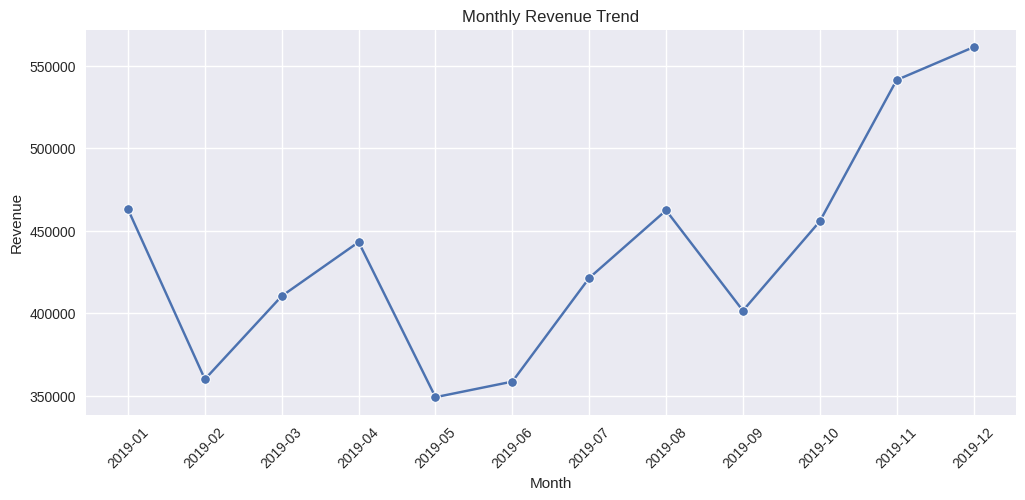

In [54]:
monthly_revenue = (
    sales.groupby("order_month")["gross_revenue"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(12,5))
sns.lineplot(data=monthly_revenue, x="order_month", y="gross_revenue", marker="o")
plt.xticks(rotation=45)
plt.title("Monthly Revenue Trend")
plt.ylabel("Revenue")
plt.xlabel("Month")
plt.show()


Revenue follows seasonal patterns, suggesting demand peaks likely driven by promotions or customer buying cycles.

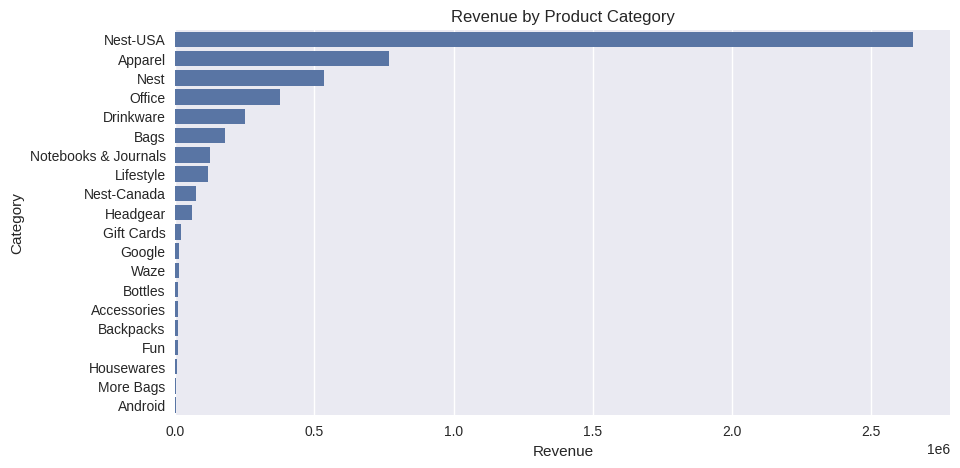

In [55]:
category_revenue = (
    sales.groupby("category")["gross_revenue"]
    .sum()
    .reset_index()
    .sort_values(by="gross_revenue", ascending=False)
)

plt.figure(figsize=(10,5))
sns.barplot(data=category_revenue, x="gross_revenue", y="category")
plt.title("Revenue by Product Category")
plt.xlabel("Revenue")
plt.ylabel("Category")
plt.show()


Revenue is concentrated in a limited number of categories, making them critical drivers of overall business performance.

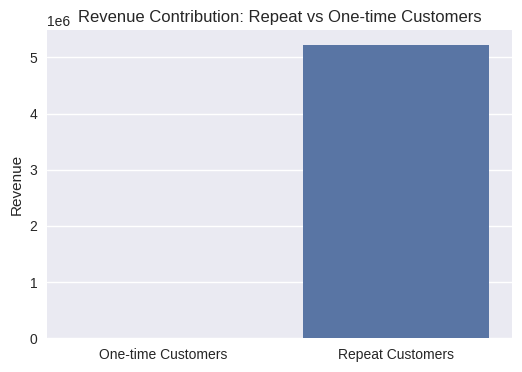

In [56]:
repeat_analysis = (
    sales.groupby("repeat_customer_flag")["gross_revenue"]
    .sum()
    .reset_index()
)

repeat_analysis["repeat_customer_flag"] = repeat_analysis["repeat_customer_flag"].map({
    0: "One-time Customers",
    1: "Repeat Customers"
})

plt.figure(figsize=(6,4))
sns.barplot(data=repeat_analysis, x="repeat_customer_flag", y="gross_revenue")
plt.title("Revenue Contribution: Repeat vs One-time Customers")
plt.ylabel("Revenue")
plt.xlabel("")
plt.show()


Repeat customers contribute significantly higher revenue than one-time buyers, highlighting retention as a key growth lever.

In [57]:
#Cohort Table

sales['first_purchase_month'] = (
    sales.groupby("customer_id")["order_date"]
    .transform("min")
    .dt.to_period("M")
    .astype(str)
)


In [58]:
cohort_data = (
    sales.groupby(["first_purchase_month", "order_month"])["customer_id"]
    .nunique()
    .reset_index()
)

cohort_pivot = cohort_data.pivot(
    index="first_purchase_month",
    columns="order_month",
    values="customer_id"
)


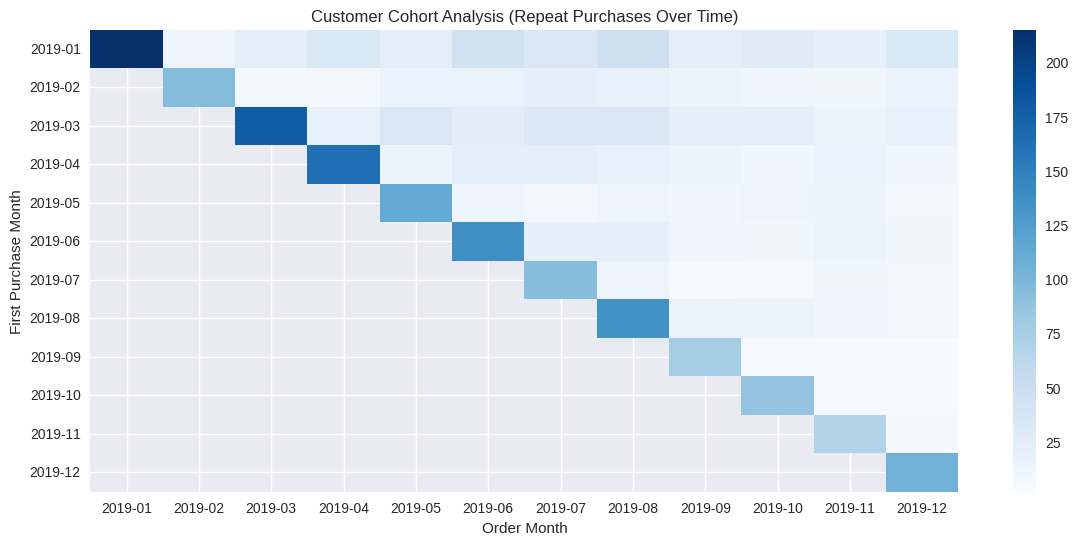

In [59]:
plt.figure(figsize=(14,6))
sns.heatmap(cohort_pivot, cmap="Blues", annot=False)
plt.title("Customer Cohort Analysis (Repeat Purchases Over Time)")
plt.xlabel("Order Month")
plt.ylabel("First Purchase Month")
plt.show()


A small subset of customers contributes a large portion of total revenue, indicating an opportunity for targeted engagement strategies.

POWER BI visulisations

In [60]:
sales.to_csv("/kaggle/working/clean_sales_data.csv", index=False)
